# Introduction

This notebook demonstrates how to set up and train PaleoBlockNet v1.0.

Reference publication: Karamperidou, C., Extracting Paleoweather from Paleoclimate: A Deep Learning Reconstruction of Northern Hemisphere Summertime Atmospheric Blocking over the Last Millennium, Nature Communications Earth & Environment, in revision (2024)

## Computational recipe

- Define the model using a UNet architecture
- Load training, validation, and testing data  
- Compile, train, and save the model.
- Plot example input, output (observed), and prediction  

## Import packages

In [1]:
from datetime import date
today = date.today().strftime('%Y-%m-%d')
print('Last Updated: ' + today) 

Last Updated: 2024-07-02


In [2]:
#Importing required packages
import os
import numpy as np
import xarray as xr

from scipy.stats import skew,stats
import scipy.signal as signal

from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
plt.rcParams.update({'figure.max_open_warning': 0})

import zarr
import fsspec
import pandas as pd

import glob as glob
import netCDF4 as nc
from netCDF4 import Dataset

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.util import add_cyclic_point

from IPython.display import clear_output
from random import sample 
import pickle as pkl

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import MeanSquaredError, CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import *
tf.config.list_physical_devices(device_type=None)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

import scipy.ndimage as ndimage

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.path import Path

import xesmf as xe
import datetime

2024-07-02 05:17:17.489125: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-02 05:17:18.294773: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.12.0
Num GPUs Available:  2


2024-07-02 05:17:19.532310: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15135 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:62:00.0, compute capability: 7.0
2024-07-02 05:17:19.533410: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30529 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:61:00.0, compute capability: 7.0


2 Physical GPUs, 2 Logical GPUs


In [ ]:
# dynamically change working directory to project_root. 
# NOTE: this works for this file structure; otherwise you need to use file markers  
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
# change the current working directory to project_root
os.chdir(project_root)
print("Changed working directory to project root:", os.getcwd())

In [4]:
# Import plotting utilities
from src.visualization import plot_utils

In [5]:
# Define model and data directories
DIR_models=f'{os.getcwd()}/models/'
DIR_data=f'{os.getcwd()}/data/'

# Build model 

In [6]:
# Define PaleoBlockNet
def unet(input_shape):
    # Encoder
    inputs = tf.keras.layers.Input(shape=input_shape,name='input')
    conv1 = tf.keras.layers.Conv2D(32, (3, 3),  padding='same',name='conv_1')(inputs)
    conv1 = tf.keras.layers.Conv2D(32, (3, 3), padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),name='pool_1')(conv1)

    conv2 = tf.keras.layers.Conv2D(64, (3, 3),  padding='same',name='conv_2')(pool1)
    conv2 = tf.keras.layers.Conv2D(64, (3, 3), padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),name='pool_2')(conv2)

    conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same',name='conv_3')(pool2)
    conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),name='pool_3')(conv3)

    # Bottleneck
    conv4 = tf.keras.layers.Conv2D(256, (3, 3), activation='linear', padding='same',name='conv_4_bottleneck')(pool3)

    # Decoder
    up1 = tf.keras.layers.UpSampling2D(size=(2, 2),name='up_1')(conv4)
    conv5 = tf.keras.layers.Conv2D(128, (3, 3),  padding='same',name='conv_5')(up1)
    merge1 = tf.keras.layers.concatenate([conv3, conv5], axis=3)

    up2 = tf.keras.layers.UpSampling2D(size=(2, 2),name='up_2')(merge1)
    conv6 = tf.keras.layers.Conv2D(64, (3, 3),  padding='same',name='conv_6')(up2)
    merge2 = tf.keras.layers.concatenate([conv2, conv6], axis=3)

    up3 = tf.keras.layers.UpSampling2D(size=(2, 2),name='up_3')(merge2)
    conv7 = tf.keras.layers.Conv2D(32, (3, 3),  padding='same',name='conv_7')(up3)
    merge3 = tf.keras.layers.concatenate([conv1, conv7], axis=3)

    conv8 = tf.keras.layers.Conv2D(1, (1, 1),name='block_output')(merge3)

    # Model
    model = tf.keras.models.Model(inputs=inputs, outputs=conv8)

    return model

# Train-validate-test (sample operations)  

## Input data

In [7]:
## get sample datasets from zenodo: https://zenodo.org/doi/10.5281/zenodo.10739678
# Sample datasets
input_train_aux = np.load(f'{DIR_data}processed/input_train_sample.npy')
input_val_aux = np.load(f'{DIR_data}processed/input_val_sample.npy')
input_test_aux = np.load(f'{DIR_data}processed/input_test_sample.npy')
# Add a channel dimension
input_train = np.expand_dims(input_train_aux, axis=-1)
input_val = np.expand_dims(input_val_aux, axis=-1)
input_test = np.expand_dims(input_test_aux, axis=-1)
input_train.shape,input_val.shape,input_test.shape

((3354, 48, 288, 1), (172, 48, 288, 1), (86, 48, 288, 1))

In [8]:
# Standardize input
mean = input_train.mean()
std = input_train.std()
input_train_z=(input_train-mean)/std
input_val_z=(input_val-mean)/std
input_test_z=(input_test-mean)/std

## Output data

In [9]:
# get sample datasets from zenodo: https://zenodo.org/doi/10.5281/zenodo.10739678
# Sample datasets
output_train_aux = np.load(f'{DIR_data}processed/output_train_sample.npy')
output_val_aux = np.load(f'{DIR_data}processed/output_val_sample.npy')
output_test_aux = np.load(f'{DIR_data}processed/output_test_sample.npy')
# Add a channel dimension
output_train = np.expand_dims(output_train_aux, axis=-1)
output_val = np.expand_dims(output_val_aux, axis=-1)
output_test = np.expand_dims(output_test_aux, axis=-1)
output_train.shape,output_val.shape,output_test.shape

((3354, 48, 288, 1), (172, 48, 288, 1), (86, 48, 288, 1))

## Build tensors for training and validation

In [10]:
# Convert numpy arrays to TensorFlow tensors
input_train_tensor = tf.convert_to_tensor(input_train_z, dtype=tf.float32)
input_val_tensor = tf.convert_to_tensor(input_val_z, dtype=tf.float32)
input_test_tensor = tf.convert_to_tensor(input_test_z, dtype=tf.float32)
#####
output_train_tensor = tf.convert_to_tensor(output_train, dtype=tf.float32)
output_val_tensor = tf.convert_to_tensor(output_val, dtype=tf.float32)
output_test_tensor = tf.convert_to_tensor(output_test, dtype=tf.float32)

# Use from_tensor_slices to create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((input_train_tensor, output_train_tensor))
val_dataset = tf.data.Dataset.from_tensor_slices((input_val_tensor, output_val_tensor))
test_dataset = tf.data.Dataset.from_tensor_slices((input_test_tensor, output_test_tensor))

# Fit PaleoBlockNet

In [ ]:
model=unet(input_train.shape[1:4])
model.summary()

In [12]:
DIR= f'{os.getcwd()}'
current_date = datetime.datetime.now().strftime("%Y-%m-%d")
EXP_NAME = f"paleoblocknet_{current_date}"

# set to True for training the model
RETRAIN = True
EVALUATE = True

OUT_PATH = f"{DIR}/models/"
PLOT_PATH = os.path.join(os.getcwd(), "plots", EXP_NAME)
MODEL_PATH = os.path.join(OUT_PATH, f"{EXP_NAME}_model")
from contextlib import redirect_stdout

In [ ]:
nbatch = 32
patience = 5
num_epochs= 5  # just as an example
train_batches = train_dataset.shuffle(len(input_train),reshuffle_each_iteration=True).batch(nbatch)
val_batches = val_dataset.batch(nbatch)

if RETRAIN:
    callbacks_list = [
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss",
                mode="min",
                patience=patience,
            ),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=os.path.join(OUT_PATH, f"{EXP_NAME}_checkpoint"),
                monitor="val_loss",
                save_best_only=True,
            ),
        ]

        # compile
    loss_weights = {'block_output': 1}
    loss= {'block_output': 'mse'}
    metrics={'block_output': 'mae'}
    init_lr = 1e-4
    epochs = 100
    opt = Adam(learning_rate=init_lr)
    model.compile(optimizer=opt, 
                  loss=loss,
                  loss_weights=loss_weights,
                  metrics=metrics)
    # run
    history = model.fit(
            train_batches,
            epochs=num_epochs,
            verbose=1,
            callbacks=callbacks_list,
            validation_data=val_batches
        )
    model.save(MODEL_PATH)

    history_dict = history.history
    tr_loss = history_dict["loss"]
    val_loss = history_dict["val_loss"]

    # save the model summary, logs
    with open(os.path.join(OUT_PATH, f"{EXP_NAME}_summary.md"), "w") as f:
        with redirect_stdout(f):
            model.summary()

    import pickle

    with open(os.path.join(OUT_PATH, "model_history.pkl"), "wb") as f:
        pickle.dump(history_dict, f)

    tr_loss = np.array(tr_loss)
    val_loss = np.array(val_loss)

    train_losses = xr.DataArray(
        tr_loss, dims=["epoch"], coords={"epoch": np.arange(1, len(tr_loss) + 1)}
    )
    val_losses = xr.DataArray(
        val_loss,
        dims=["epoch"],
        coords={"epoch": np.arange(1, len(val_loss) + 1)},
        attrs={"long_name": "Validation Loss"},
    )

    train_losses.to_netcdf(os.path.join(OUT_PATH, f"{EXP_NAME}_train_losses.nc"))
    val_losses.to_netcdf(os.path.join(OUT_PATH, f"{EXP_NAME}_val_losses.nc"))

else:
    train_losses = xr.open_dataarray(
        os.path.join(OUT_PATH, f"{EXP_NAME}_train_losses.nc")
    )
    val_losses = xr.open_dataarray(os.path.join(OUT_PATH, f"{EXP_NAME}_val_losses.nc"))

    import pickle

    with open(os.path.join(OUT_PATH, "model_history.pkl"), "wb") as f:
        history_dict = pickle.load(f)

# Example test

In [14]:
pr=model.predict(input_test_z) # Make prediction

3/3 [==============================] - 1s 287ms/step


In [15]:
# Turn predictions into xarray for plotting: 
model_grid=xr.open_dataset(f'{DIR_data}processed/model_grid.nc')  
pr_xr = xr.DataArray(
    data=pr.squeeze(),
    dims=['time', 'lat', 'lon'],
    coords={
        'time': range(pr.shape[0]),  
        'lat': model_grid['lat'].sel(lat=slice(30,75)),
        'lon': model_grid['lon']
    }
)

In [16]:
# Turn observed into xarray for plotting: 
output_xr = xr.DataArray(
    data=output_test.squeeze(),
    dims=['time', 'lat', 'lon'],
    coords={
        'time': range(output_test.shape[0]),  
        'lat': model_grid['lat'].sel(lat=slice(30,75)),
        'lon': model_grid['lon']
    }
)
# turn input into xarray for plotting: 
input_xr = xr.DataArray(
    data=input_test.squeeze(),
    dims=['time', 'lat', 'lon'],
    coords={
        'time': range(input_test.shape[0]),  
        'lat': model_grid['lat'].sel(lat=slice(30,75)),
        'lon': model_grid['lon']
    }
)

In [17]:
# add cyclic plot for plotting purposes 
pr_xr_plot=plot_utils.add_cyclic_point_to_dataarray(pr_xr*100)
output_xr_plot=plot_utils.add_cyclic_point_to_dataarray(output_xr*100)
input_xr_plot=plot_utils.add_cyclic_point_to_dataarray(input_xr)

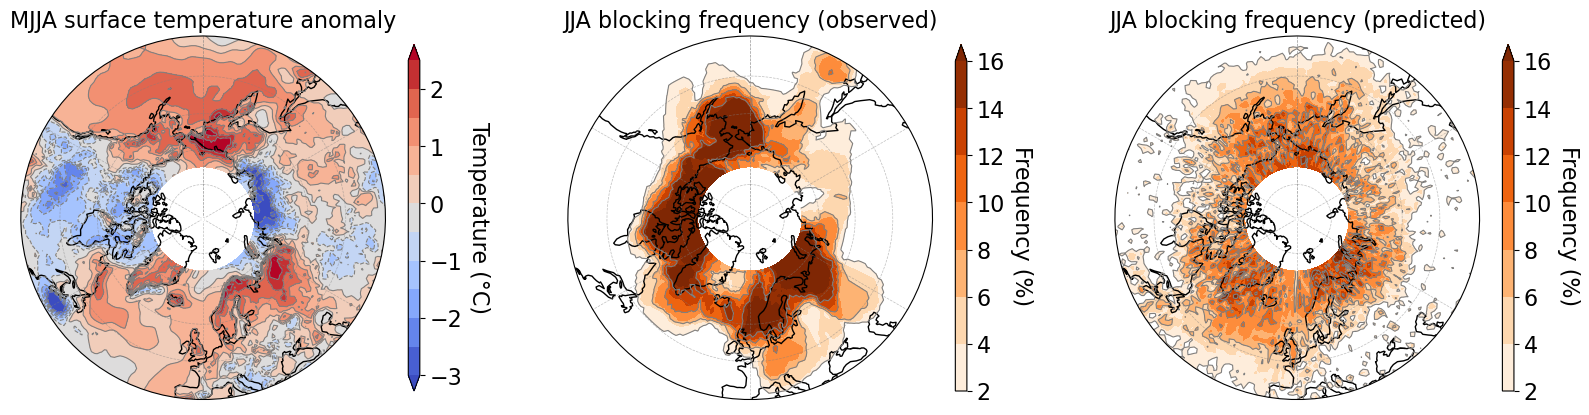

In [18]:
jja_freq_plots = [input_xr_plot[0], output_xr_plot[0], pr_xr_plot[0]]
titles = ['MJJA surface temperature anomaly','JJA blocking frequency (observed)','JJA blocking frequency (predicted)']
n_plots=len(jja_freq_plots)
n_cols = 3  # Set number of columns per row
n_rows = (n_plots + n_cols - 1) // n_cols

# Create subplots
fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(20, 5 * n_rows), 
                        subplot_kw={'projection': ccrs.NorthPolarStereo()},
                        squeeze=False)  # Ensures axs is always a 2D array

lat_lims = [40, 90]

legendkw = [dict(levels=np.arange(-3, 3, 0.5), cmap='coolwarm', extend='both', transform=ccrs.PlateCarree()),
            dict(levels=np.arange(2, 18, 2), cmap='Oranges', extend='max', transform=ccrs.PlateCarree()),
            dict(levels=np.arange(2, 18, 2), cmap='Oranges', extend='max', transform=ccrs.PlateCarree())
           ]
contourkw = [dict(colors='grey', linewidths=0.8, levels=np.arange(-3, 3, 0.5), transform=ccrs.PlateCarree()),
             dict(colors='grey', linewidths=0.8, levels=np.arange(2, 18, 4), transform=ccrs.PlateCarree()),
             dict(colors='grey', linewidths=0.8, levels=np.arange(2, 18, 4), transform=ccrs.PlateCarree())
            ]

cbar_labels= ['Temperature (°C)','Frequency (%)','Frequency (%)']


for i, ax in enumerate(axs.flatten()):
    plot_utils.polar_set_latlim(lat_lims, ax,ccrs.PlateCarree())
    cf = ax.contourf(jja_freq_plots[i].lon, jja_freq_plots[i].lat, jja_freq_plots[i], **legendkw[i])
    cs=ax.contour(jja_freq_plots[i].lon, jja_freq_plots[i].lat, jja_freq_plots[i], **contourkw[i])
    ax.coastlines()
    ax.set_title(titles[i], fontsize=16)
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    cbar = plt.colorbar(cf, ax=ax, shrink=0.9, orientation='vertical', aspect=30)
    cbar.ax.get_yaxis().labelpad = 20
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.set_ylabel(cbar_labels[i], rotation=-90, size=16)

fig.suptitle('', fontsize=20, x=0.45)
plt.show()

# Sample evaluation plot

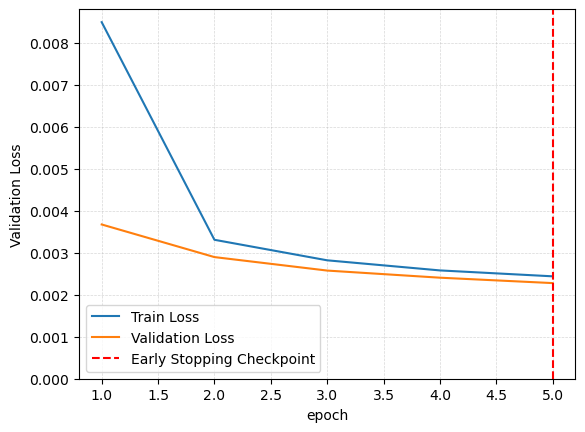

In [19]:
fig, ax = plt.subplots()
train_losses.plot(ax=ax, label="Train Loss")
val_losses.plot(ax=ax, label="Validation Loss")
ax.axvline(
    val_losses.argmin() + 1,
    color="r",
    linestyle="--",
    label="Early Stopping Checkpoint",
)
ax.legend()
ax.set_ylim(0, None)
ax.grid(ls="--", lw=0.5, alpha=0.5)
fig.savefig(f'{DIR}/reports/figures/losses_{EXP_NAME}.png', bbox_inches = 'tight')
